## Imports, Classes, and Constants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

import concurrent.futures
import time

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.base import clone

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

RANDOM_SEED = 42

class StemCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemCountVectorizer, self).build_analyzer()
        
        return lambda document: ([SnowballStemmer('english', ignore_stopwords=True).stem(word) for word in analyzer(document)])

## Dataset Preprocessing

In [2]:
mcu_subset = pd.read_csv("./data/mcu_subset.csv")

np.random.seed(RANDOM_SEED)
mcu_subset = mcu_subset.reindex(np.random.permutation(mcu_subset.index))

mcu_subset.head()

,Unnamed: 0,character,line,movie,year,words,Adam McKay,Anna Boden,Art Marcum,Ashley Edward Miller,...,Joss Whedon,Justin Theroux,Mark Fergus,Matt Holloway,Paul Rudd,Ryan Coogler,Ryan Fleck,Shane Black,Stephen McFeely,Zack Stentz
3393,6565,STEVE ROGERS,"People are gonna die, Buck. I can't let that happen. Please, don't make me do this.",Captain America: The Winter Soldier,2014,17,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4909,11269,PETER PARKER,"Yeah, actually, I don’t intern for him anymore.",Spider-Man: Homecoming,2017,8,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4815,11073,PETER PARKER,Who are these guys? What can you tell me about the guy with the wings?,Spider-Man: Homecoming,2017,15,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3434,6641,STEVE ROGERS,You don't have to come with me.,Captain America: The Winter Soldier,2014,7,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
96,143,TONY STARK,"Finally, I want: three pairs of tube socks, white, a toothbrush, protein powder, spices, sugar, five pounds of tea, cards. And a washing machine. Top load.",Iron Man,2008,29,False,False,True,False,...,False,False,True,True,False,False,False,False,False,False


In [3]:
pd.DataFrame(mcu_subset['character'].value_counts())

,character
TONY STARK,1787
STEVE ROGERS,977
THOR,863
PETER PARKER,551
NATASHA ROMANOFF,498
PEPPER POTTS,441
BRUCE BANNER,379
NICK FURY,366
LOKI,327
JAMES RHODES,318


In [4]:
y = mcu_subset["character"].to_numpy().astype(str)
X = mcu_subset["line"].to_numpy().astype(str)

X[0:10], y[0:10]

(array(["People are gonna die, Buck. I can't let that happen.  Please, don't make me do this.",
        'Yeah, actually, I don’t intern for him anymore.',
        'Who are these guys? What can you tell me about the guy with the wings?',
        "You don't have to come with me.",
        'Finally, I want: three pairs of tube socks, white, a toothbrush, protein powder, spices, sugar, five pounds of tea, cards.  And a washing machine.  Top load. ',
        "We're not salvaging anything. We're not just taking down the carriers, Nick, we're taking down SHIELD.",
        'The September Foundation.', "Kid, that's the wizard. Get on it.",
        'Okay, Clint.  Starting in three, two, one...',
        "You know damn well! You know damn well who!  She wouldn't want us to fight."],
       dtype='<U1388'),
 array(['STEVE ROGERS', 'PETER PARKER', 'PETER PARKER', 'STEVE ROGERS',
        'TONY STARK', 'STEVE ROGERS', 'TONY STARK', 'TONY STARK',
        'BRUCE BANNER', 'THOR'], dtype='<U16'))

## Models

In [5]:
cross_validator = StratifiedKFold(n_splits=100, random_state=RANDOM_SEED, shuffle=True)
score_method = "balanced_accuracy"

In [6]:
class OVR_Model(BaseEstimator):
    def __init__(self, base_model):
        self.base_model = base_model
        self.models = []
        self.classes_ = []
        
    def fit(self, X, y, verbose=False):
        
        self.classes_ = np.unique(y)
        
        def train_model(X,y,label):
            if verbose:
                import warnings
                warnings.simplefilter('always')
                warnings.warn("Training a model model '" + label + "'")
                start = time.time()
            
            binary_y = (y == np.full(y.shape, label))
            new_model = clone(self.base_model)
            new_model.fit(X, binary_y)
            
            return new_model
            
            if verbose:
                end = time.time()
                warnings.warn("Finished training model '" + label + "'.  Elapsed time: " + str(end-start) + "s")
                
        with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
            futures = []
            for label in self.classes_:
                futures.append(executor.submit(train_model, X, y, label))
                
            for i in range(0,len(futures)):
                try:
                    new_model = futures[i].result()
                    self.models.append(new_model)
                except Exception as exc:
                    print('Training %r generated an exception: %s' % (self.classes_[i], exc))            
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]
        
    def predict_proba(self, X, verbose=False):
        probabilities = np.empty(shape=(len(X), 0))
                                 
        def predict_proba_model(model,x):
            if verbose:
                import warnings
                warnings.simplefilter('always')
                warnings.warn("Predicting using model '" + label + "'")
                start = time.time()
                                 
            label_probs = model.predict_proba(x)[:, list(model.classes_).index(True)]
            
            if verbose:
                end = time.time()
                warnings.warn("Finished predicting using model '" + label + "'.  Elapsed time: " + str(end-start) + "s")
                                 
            return label_probs
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
            futures = []
            for model in self.models:
                futures.append(executor.submit(predict_proba_model, model, X))
                
            for i in range(0,len(futures)):
                try:
                    label_probs = futures[i].result()
                except Exception as exc:
                    print('Exception Generated: %s' % (exc))
                else:
                    probabilities = np.concatenate((probabilities, np.expand_dims(label_probs, axis=1)), axis=1)
         
        return probabilities
        

In [7]:
base_model = Pipeline(steps=[('vect', StemCountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf', MultinomialNB(alpha=0.01, fit_prior=False))])

model_14 = OVR_Model(base_model)

## Nested CV Balanced Accuracy

In [8]:
models = {"model_14": model_14}

cv_score_table = pd.DataFrame()

for name, model in models.items():
    results = cross_val_score(model, X, y, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=6)
    cv_score_table.insert(len(cv_score_table.columns), name, results, True)

cv_score_table.index.name = "fold"
cv_score_table.loc["mean"] = cv_score_table.mean()
cv_score_table.loc["std"] = cv_score_table.std()
cv_score_table.loc["max"] = cv_score_table.max()

cv_score_table

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 53.4min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 150.9min remaining:  9.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 157.7min finished


,model_14
fold,
0,0.083333
1,0.115000
2,0.212778
3,0.078333
4,0.058333
5,0.036667
6,0.050000
7,0.136667
8,0.075000


## Confusion Matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 51.3min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 148.8min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 156.0min finished


Balanced Accuracy: 0.28966296855207674
Balanced Accuracy: 0.28966296855207674


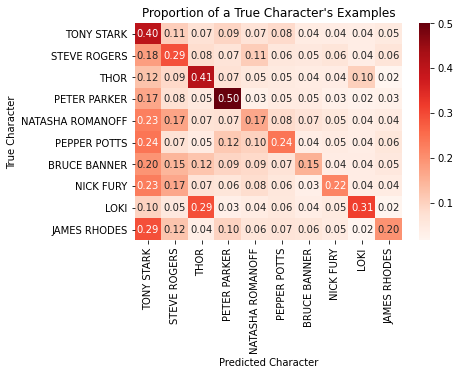

In [9]:
yhat = cross_val_predict(model_14, X, y, cv=cross_validator, n_jobs=-1, verbose=6)

main_characters = mcu_subset['character'].value_counts().index.to_numpy()

conf_matrix = pd.DataFrame(metrics.confusion_matrix(y, yhat, labels=main_characters))
normalized_conf_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
normalized_conf_matrix.columns = pd.Series(main_characters, name="Predicted Character")
normalized_conf_matrix.index = pd.Series(main_characters, name="True Character")

plt.title("Proportion of a True Character's Examples")
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(normalized_conf_matrix)))